In [ ]:
using Revise

In [ ]:
using TaylorSeries, Plots

function step!(f, y, n, t, h)
    k₁ = f(t[n], y[n])
    k₂ = f(t[n] + h/2, y[n] + h*k₁/2)
    k₃ = f(t[n] + h/2, y[n] + h*k₂/2)
    k₄ = f(t[n] + h, y[n] + h*k₃)
    y[n+1] = y[n] + (h/6) * (k₁ + 2k₂ + 2k₃ + k₄)
    t[n+1] = t[n] + h
end

function solve(f, h, t₀, T, y₀)
    N = round(Int, (T - t₀) / h)
    t = Vector{Float64}(undef, N)
    y = Vector{typeof(y₀)}(undef, N)
    y[1] = y₀; t[1] = t₀; 
    for n in 1:N-1
        step!(f, y, n, t, h)
    end
    y, t
end

#augmented eom
function f_quad(t, y) 
    [1 - y[1]^2, 2*y[2]*y[1] ]
end

In [ ]:
_tend = 1.0
ξ = Taylor1(25)
set_taylor1_varname("ξ")
u0 = 0.0
g(x) = x^2

In [ ]:
# define IC, note second state IC is just a change of variables of the 1st. Leading to a Taylor expansion of g(x) for 2nd state
_u0ξ = u0 + ξ
u0ξ = [_u0ξ, g(_u0ξ)]

plot(x->u0ξ[2](x),-1,1)  # TaylorSeries expansion of g(x).

In [ ]:
y, t = solve(f_quad, 0.01, 0.0, _tend, u0ξ);
xrange = range(-1,1, length=100)
y2max = maximum([maximum(_y[2].(xrange)) for _y in y])

anim = @animate for (yi,ti) ∈ zip(y,t)
    _y1 = yi[1].(xrange)
    _y2 = yi[2].(xrange)
    plot(_y1, _y2, leg = false, lw = 3, xlabel = "y1", ylabel = "y2")
    vline!(_y1[1:3:end])
    title!("t = $(round(ti*100)/100)")
    ylims!(0.0,y2max)
end

gif(anim, fps=15)

## Flowpipe computation

In [1]:
using Revise

using LazySets
using ReachabilityAnalysis
using TaylorModels
using Plots
using MDBM

const RA = ReachabilityAnalysis
using ReachabilityAnalysis: post

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1278
┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


In [2]:
@taylorize function f_quad!(dy, y, p, t) 
    dy[1] = 1 - y[1]^2
    dy[2] = 2*y[1]*y[2]
end

In [4]:
n = 2
orderQ = 2
orderT = 8
x = set_variables("x", numvars=n, order=orderQ)

xtm1 = TaylorModel1(Taylor1(x[1], orderT), RA.zeroI, RA.zeroI, RA.zeroI)
xtm2 = TaylorModel1(Taylor1(x[1]^2, orderT), RA.zeroI, RA.zeroI, RA.zeroI)

X0tm = TaylorModelReachSet([xtm1, xtm2], RA.zeroI)

alg = TMJets(orderT=8, orderQ=2, abs_tol=1e-13)
ivp = @ivp(x' = f_quad!(x), x(0) ∈ X0tm, dim=2)
sol = post(alg, ivp, 0 .. 1.0);

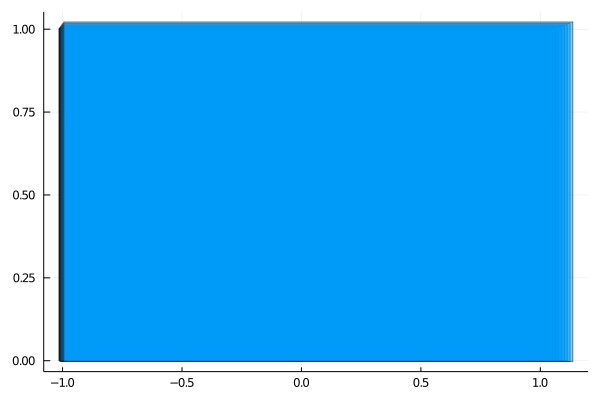

In [7]:
plot(sol[1:10], vars=(1,2))

In [11]:
set(sol[1])

2-element Array{TaylorModel1{TaylorN{Float64},Float64},1}:
   1.0 x₁ + ( 1.0 - 1.0 x₁²) t + ( - 1.0 x₁) t² + ( - 0.3333333333333333 + 1.3333333333333333 x₁²) t³ + ( 0.6666666666666666 x₁) t⁴ + ( 0.13333333333333333 - 1.1333333333333333 x₁²) t⁵ + ( - 0.37777777777777777 x₁) t⁶ + ( - 0.053968253968253964 + 0.7873015873015873 x₁²) t⁷ + ( 0.19682539682539682 x₁) t⁸ + [-2.37287e-17, 2.11447e-17]
                                                                                                                                                                                        1.0 x₁² + ( 1.0 x₁²) t² + ( 0.33333333333333337 x₁²) t⁴ + ( 0.04444444444444446 x₁²) t⁶ + ( 0.003174603174603179 x₁²) t⁸ + [-2.51666e-16, 2.51666e-16]

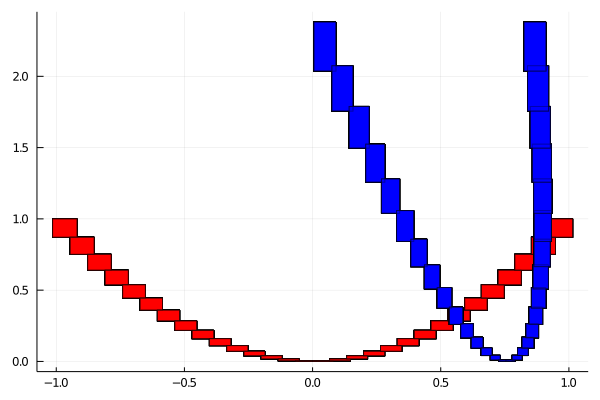

In [8]:
plot(UnionSetArray(overapproximate(sol[1], Hyperrectangle, 30).X.array), c=:red)

plot!(UnionSetArray(overapproximate(sol[end], Hyperrectangle, 30).X.array), c=:blue)

In [49]:
tend(sol[2])

0.02876519088414342

In [52]:
sup(domain(R))

0.014387335048173366

In [73]:
#X = set(X0tm)
R = sol[end]
X = set(R)

X_Δt = TaylorModels.evaluate(X, sup(domain(R))) #     # tend(R) - sup(domain(R))); # tiempo 0

In [74]:
X̂ = [TaylorModelN(X_Δt[j], X[j].rem, RA.zeroBox(n), RA.symBox(n)) for j in 1:n]
#TaylorModelN(X_Δt[j], X[j].rem, RA.zeroBox(n), RA.symBox(n))
fX̂ = TaylorModels.fp_rpa.(X̂)

aa(x, y) = mid(TaylorModels.evaluate(fX̂[1], [x, y]))
bb(x, y) = mid(TaylorModels.evaluate(fX̂[2], [x, y]))

#TaylorSeries.evaluate(TaylorModels.evaluate(set(X0tm)[1], 0.0), (-1.0, -1.0))

bb (generic function with 1 method)

In [77]:
X[2]

  2.3382941027297655 x₁² + ( 3.5379797671162754 x₁²) t + ( 3.676588205459531 x₁²) t² + ( 2.3586531780775166 x₁²) t³ + ( 1.2255294018198435 x₁²) t⁴ + ( 0.4717306356155033 x₁²) t⁵ + ( 0.16340392024264577 x₁²) t⁶ + ( 0.04492672720147649 x₁²) t⁷ + ( 0.011671708588760389 x₁²) t⁸ + [-2.25422e-13, 2.2457e-13]

In [75]:
#f(x, y) = [x - aa(x, y), y - bb(x, y)]
#norm(y - bb(x, y), 2.0) + norm(x - aa(x, y), 2.0) # y^2 + bb(x, y)^2.0 - 2*y*bb(x, y) # + (x - aa(x, y))^2.0 #(x - aa(x, y))^2.0 + (y - bb(x, y))^2.0

  0.010456 seconds (6.43 k allocations: 394.648 KiB)
  0.060955 seconds (414.98 k allocations: 24.637 MiB)
  0.065463 seconds (81.15 k allocations: 10.229 MiB, 78.96% gc time)


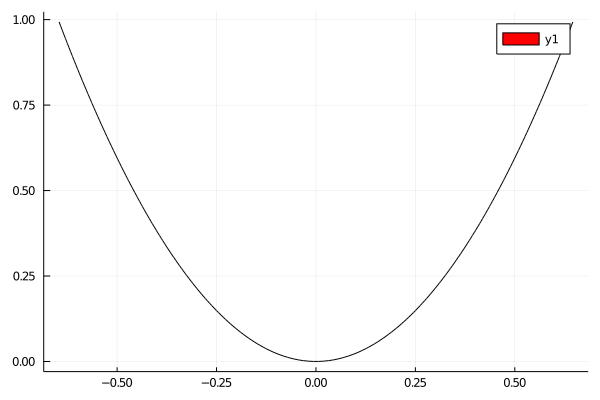

In [76]:
#f(x, y) = x^2.0+y^2.0-2.0^2.0
#f(x,y) = (x^4 + y^4 - 1) * (x^2 + y^2 - 2) + x^5 * y
xs = Axis(-1:0.1:1, "x")
ys = Axis(-1:0.1:1, "y")

function c(x, y)
    1
end

f1(x, y) = x - aa(x, y)  # x - x # aa(x, y)
f2(x, y) = y - bb(x, y)
function f3(x, y)
    return f2(x, y)
end
@time m = MDBM_Problem(f3, [xs, ys]);

@time solve!(m, 3);

@time mdt = MDBM.connect(m);

xcoords = []
ycoords = []

for i in 1:length(mdt)
    dt = mdt[i]
    P1 = getinterpolatedsolution(m.ncubes[dt[1]], m)
    P2 = getinterpolatedsolution(m.ncubes[dt[2]], m)
    push!(xcoords, P1[1])
    push!(ycoords, P1[2])
    push!(xcoords, P2[1])
    push!(ycoords, P2[2])

    push!(xcoords, NaN)
    push!(ycoords, NaN)
end

Plots.plot(xcoords, ycoords, seriestype=:shape, fillcolor=:red, fillalpha=1.)

In [ ]:
n = 2
orderQ = 2
orderT = 8
x = set_variables("x", numvars=n, order=orderQ)

xtm1 = TaylorModel1(Taylor1(x[1], orderT), RA.zeroI, RA.zeroI, RA.zeroI)
xtm2 = TaylorModel1(Taylor1(x[1]^2, orderT), RA.zeroI, RA.zeroI, RA.zeroI)

X0tm = TaylorModelReachSet([xtm1, xtm2], RA.zeroI)

In [ ]:
overapproximate(X0tm, TaylorModelReachSet)

In [ ]:
X0tm.X[2]

In [ ]:
Z = overapproximate(X0tm, Zonotope).X

genmat(Z) |> Matrix

In [ ]:
LazySets.center(Z)

In [ ]:
H = overapproximate(X0tm, Hyperrectangle, 20).X

plot(UnionSetArray(H.array), c=:red) # SLOW ??

In [ ]:
vertices_list(H.array[4])

In [ ]:
R = ReachSet(rand(Zonotope), 0 .. 1)
T = overapproximate(R, TaylorModelReachSet)
T.X[1]

In [ ]:
t = Taylor1(TaylorN{Float64}, 1)

----

In [ ]:
X0tm

In [ ]:
sol[1]

In [ ]:
genmat(set(overapproximate(sol[7], Zonotope))) |> Matrix

In [ ]:
sol[7].X[2]

In [ ]:
plot(sol, vars=(1, 2))

In [ ]:
plot(UnionSetArray(overapproximate(sol[1], Hyperrectangle, 30).X.array), c=:red)
plot!(UnionSetArray(overapproximate(sol[end], Hyperrectangle, 30).X.array), c=:blue)

In [ ]:
tspan.(sol)

In [ ]:
overa